## 0. Import

In [1]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np

In [2]:
train = pd.read_csv("trade_train.csv")
stocks = pd.read_csv("stocks.csv")

In [3]:
stock_name_code=stocks[['기준일자','종목번호','종목명']]
stock_name_code_last=stock_name_code[stock_name_code['기준일자']==20200728]
del stock_name_code_last['기준일자']

In [4]:
train = pd.merge(train, stock_name_code_last, on = '종목번호', how = 'left')
train.head()

,Unnamed: 0,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값,종목명
0,0,201907,MAD01,288,A000660,Y,Y,7,17,19,234,74800,78500,SK하이닉스
1,1,201907,MAD01,288,A001820,Y,Y,3,4,533,154,47385,46700,삼화콘덴서
2,2,201907,MAD01,288,A004020,Y,Y,3,3,409,528,41411,40000,현대제철
3,3,201907,MAD01,288,A005380,Y,Y,4,3,323,451,140602,140628,현대차
4,4,201907,MAD01,288,A005930,Y,Y,13,19,34,101,45350,46850,삼성전자


## 1. 그룹별 매수 종목 Sequence

In [5]:
tmp = train.groupby(['기준년월', '그룹번호', '종목명'])['매수고객수'].sum().reset_index()
tmp = tmp[tmp['매수고객수']!=0]

In [6]:
from collections import OrderedDict
g_num = tmp['그룹번호'].unique()
a = OrderedDict()

for i in g_num:
    a[i] = []
    
for i in tmp.iterrows():
    val = a[i[1][1]]
    val.append(i[1][2])
    a[i[1][1]] = val
    
index = list(a.keys())
# index.sort()
res = []
for i in index:
    res.append(a[i])
    
seq = pd.DataFrame({'그룹번호':tmp['그룹번호'].unique(), '시퀀스':res})

seq.head()

,그룹번호,시퀀스
0,MAD01,"[LG디스플레이, LG전자, SK하이닉스, 삼성SDI, 삼성전기, 삼성전자, 삼성전..."
1,MAD02,"[두산인프라코어, 미래에셋대우, SK하이닉스, 삼성전자, 신라젠, 삼성전자, 신라젠..."
2,MAD03,"[SKC솔믹스, 고려산업, 국일제지, 대모, 동진쎄미켐, 모나미, 미래산업, 미스터..."
3,MAD04,"[GV, KB금융, KT, LG디스플레이, LG전자, LG화학, OQP, PI첨단소..."
4,MAD05,"[LG화학, OQP, SK텔레콤, SK하이닉스, 경인양행, 국일제지, 남성, 대모,..."


## 2. Word2Vec

In [7]:
model = Word2Vec(seq['시퀀스'], size=400, window = 5, min_count=0)

In [8]:
model['삼성전자']

c:\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 5.17886542e-02,  2.13457625e-02,  6.42159656e-02,  1.99113965e-01,
       -1.59911253e-02,  1.26035199e-01,  1.65133044e-01,  2.49625407e-02,
       -4.91704084e-02, -2.13891447e-01, -5.12264483e-02, -1.19632326e-01,
       -5.81503380e-03,  5.34587875e-02, -8.91920403e-02, -3.59395258e-02,
        5.16376942e-02,  5.27658425e-02, -3.36066484e-02,  9.26113874e-02,
        2.02315021e-02,  7.43528903e-02,  5.76438084e-02,  1.14706028e-02,
       -2.34693393e-01, -7.80726075e-02, -1.83545813e-01,  2.63704062e-02,
        4.55430821e-02, -2.09604383e-01,  1.53129712e-01,  3.19880471e-02,
       -6.00757971e-02, -1.76053599e-01, -1.24798864e-01,  1.73468709e-01,
       -1.08254561e-02,  2.99159616e-01, -5.18639386e-02, -8.10765624e-02,
       -8.63199532e-02,  1.76699869e-02, -7.72366375e-02, -1.77453488e-01,
       -3.42553444e-02, -1.63591683e-01,  4.26242165e-02,  5.41315367e-03,
       -1.72983781e-01,  1.49862185e-01, -1.49675146e-01,  7.26745278e-02,
        1.66980684e-01,  

In [9]:
# print n most similar stocks 

d = model.most_similar('삼성전자')
for x, y in d:
    print("%s - %f"%(x, y))

삼성전자우 - 0.999552
삼성전기 - 0.999506
삼성바이오로직스 - 0.999233
삼성SDI - 0.999149
삼성엔지니어링 - 0.998881
삼성중공업 - 0.998588
삼성물산 - 0.997969
삼성생명 - 0.996746
셀트리온 - 0.994515
삼성SDS - 0.993640


c:\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


## 3. Visualize

In [10]:
word_vectors = model.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys=xys[:,1]

In [11]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['cmr10',
 'DejaVu Sans Display',
 'STIXNonUnicode',
 'STIXSizeOneSym',
 'STIXSizeTwoSym',
 'cmb10',
 'STIXSizeThreeSym',
 'DejaVu Sans Mono',
 'DejaVu Sans',
 'STIXGeneral',
 'STIXSizeFourSym',
 'DejaVu Sans',
 'DejaVu Serif',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'cmtt10',
 'DejaVu Serif Display',
 'STIXGeneral',
 'STIXNonUnicode',
 'DejaVu Sans Mono',
 'cmsy10',
 'STIXNonUnicode',
 'cmss10',
 'STIXGeneral',
 'DejaVu Serif',
 'STIXSizeFiveSym',
 'DejaVu Serif',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeThreeSym',
 'STIXSizeFourSym',
 'cmex10',
 'DejaVu Sans',
 'cmmi10',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'STIXSizeTwoSym',
 'STIXSizeOneSym',
 'Adobe Naskh',
 'Gloucester MT Extra Condensed',
 'Symbol',
 'Informal Roman',
 'Goudy Old Style',
 'Monotype Corsiva',
 'HYGothic-Extra',
 'Adobe Song Std',
 'HYGungSo-Bold',
 'Comic Sans MS',
 'Myriad Hebrew',
 'Script MT Bold',
 'Constantia',
 'Ink Free',
 'Perpetua',
 'Segoe UI',
 'Nueva Std',
 'Courier New',
 'Segoe UI',
 'Bodoni MT',

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arita-dotum4.0(TTF)'

c:\python\python36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\python\python36\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


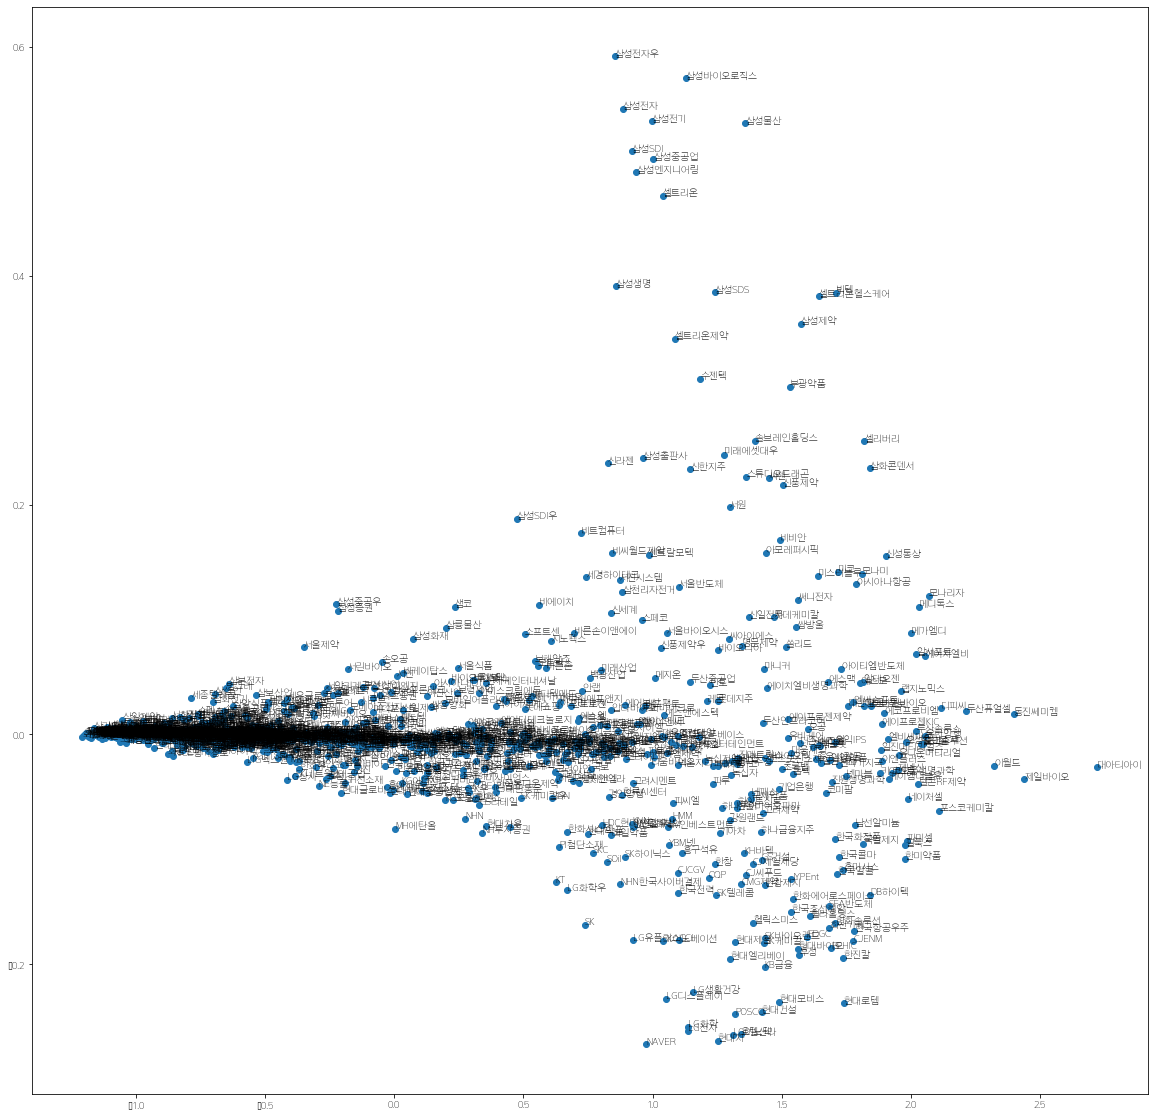

In [13]:
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(20,20))
    plt.scatter(xs,ys,marker='o')
    for i,v in enumerate(vocabs):
        plt.annotate(v,xy=(xs[i], ys[i]))
        
plot_2d_graph(vocabs, xs,ys)

## 4. Create Matrix

https://ratsgo.github.io/natural%20language%20processing/2017/03/08/word2vec/

### 4-1. Vector

In [14]:
vector = pd.DataFrame({'종목명':list(vocabs), '벡터':word_vectors_list})
vector.head()

,종목명,벡터
0,LG디스플레이,"[0.07591589, 0.036950435, 0.07401889, 0.146790..."
1,LG전자,"[0.07438617, 0.044864114, 0.077799916, 0.14778..."
2,SK하이닉스,"[0.05632733, 0.04807317, 0.06489648, 0.1365346..."
3,삼성SDI,"[0.056094743, 0.03210743, 0.06214187, 0.194692..."
4,삼성전기,"[0.056652665, 0.02420511, 0.06566113, 0.206579..."


### 4-2. Similarity Matrix

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(np.array(word_vectors_list))
similarity_matrix = pd.DataFrame(data = similarity, index = vector['종목명'], columns = vector['종목명'])
similarity_matrix.head()

종목명,LG디스플레이,LG전자,SK하이닉스,삼성SDI,삼성전기,삼성전자,삼성전자우,삼화콘덴서,한미약품,현대제철,...,휴메딕스,싸이맥스,피델릭스,아스트,미래에셋대우2우B,벽산,동아지질,에쎈테크,월덱스,아이앤씨
종목명,,,,,,,,,,,,,,,,,,,,,
LG디스플레이,1.000000,0.999267,0.995684,0.944291,0.943609,0.938279,0.929663,0.981138,0.990501,0.992553,...,0.931556,0.975740,0.988146,0.984270,0.989243,0.988265,0.982530,0.980805,0.988014,0.983489
LG전자,0.999267,1.000000,0.996836,0.940811,0.939672,0.934798,0.925591,0.976689,0.985657,0.987808,...,0.928121,0.971334,0.983779,0.979732,0.985523,0.984171,0.977983,0.976527,0.983608,0.979241
SK하이닉스,0.995684,0.996836,1.000000,0.957766,0.956131,0.952338,0.944070,0.982661,0.984679,0.984385,...,0.928698,0.973662,0.984484,0.982187,0.988589,0.986383,0.979662,0.977477,0.984303,0.980250
삼성SDI,0.944291,0.940811,0.957766,1.000000,0.999590,0.999149,0.998360,0.984091,0.958508,0.948853,...,0.902359,0.960609,0.961765,0.968630,0.974117,0.969446,0.963449,0.954690,0.962903,0.961941
삼성전기,0.943609,0.939672,0.956131,0.999590,1.000000,0.999506,0.998983,0.984960,0.959355,0.949544,...,0.901811,0.961429,0.962388,0.969322,0.974306,0.969858,0.964089,0.955346,0.963702,0.962714


### 4-3. Count Matrix

In [16]:
count_matrix = pd.pivot_table(train, index = '그룹번호', columns = '종목명', values = '매수고객수', aggfunc = 'sum')
count_matrix = count_matrix.fillna(0)
count_matrix = count_matrix.astype(int)
count_matrix = count_matrix[similarity_matrix.columns]
count_matrix.head()

종목명,LG디스플레이,LG전자,SK하이닉스,삼성SDI,삼성전기,삼성전자,삼성전자우,삼화콘덴서,한미약품,현대제철,...,휴메딕스,싸이맥스,피델릭스,아스트,미래에셋대우2우B,벽산,동아지질,에쎈테크,월덱스,아이앤씨
그룹번호,,,,,,,,,,,,,,,,,,,,,
MAD01,32,171,354,146,164,581,211,13,7,3,...,0,0,0,0,0,0,0,0,0,0
MAD02,13,13,37,0,0,135,19,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MAD03,0,3,20,14,0,126,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MAD04,31,114,472,231,175,1080,263,19,16,4,...,0,0,0,0,0,0,0,0,0,0
MAD05,7,52,161,146,98,716,153,6,8,10,...,0,0,0,0,0,0,0,0,0,0


### 4-4. Binary Matrix

In [17]:
binary_matrix = count_matrix[count_matrix > 0]
binary_matrix = binary_matrix.fillna(0)
binary_matrix.head()

종목명,LG디스플레이,LG전자,SK하이닉스,삼성SDI,삼성전기,삼성전자,삼성전자우,삼화콘덴서,한미약품,현대제철,...,휴메딕스,싸이맥스,피델릭스,아스트,미래에셋대우2우B,벽산,동아지질,에쎈테크,월덱스,아이앤씨
그룹번호,,,,,,,,,,,,,,,,,,,,,
MAD01,32.0,171.0,354.0,146.0,164.0,581,211.0,13.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MAD02,13.0,13.0,37.0,0.0,0.0,135,19.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MAD03,0.0,3.0,20.0,14.0,0.0,126,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MAD04,31.0,114.0,472.0,231.0,175.0,1080,263.0,19.0,16.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MAD05,7.0,52.0,161.0,146.0,98.0,716,153.0,6.0,8.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Final Matrix 

### 5-1.  Final Matrix1 : multply count_matrix and similarity_matrix

In [18]:
# multiply matrix
mul_matrix = np.matmul(count_matrix, similarity_matrix)
mul_matrix_T = mul_matrix.T
mul_matrix_T.head()

그룹번호,MAD01,MAD02,MAD03,MAD04,MAD05,MAD06,MAD07,MAD08,MAD09,MAD10,...,MAD39,MAD40,MAD41,MAD42,MAD43,MAD44,MAD45,MAD46,MAD47,MAD48
종목명,,,,,,,,,,,,,,,,,,,,,
LG디스플레이,2276.354952,601.349396,3076.481656,9670.085750,10281.589456,26901.733962,534.176511,5990.774443,8144.675581,366.662426,...,701.310349,283.858302,27428.243410,10703.486515,33813.901213,2062.086601,1112.149689,8493.672716,1763.216280,1236.954646
LG전자,2270.405095,599.374097,3062.875632,9633.860534,10241.536384,26802.086530,532.750281,5965.891592,8114.179940,365.457683,...,698.547627,282.956321,27310.586479,10658.192593,33697.842598,2056.148790,1108.851883,8467.457514,1758.419973,1233.412883
SK하이닉스,2291.223484,602.990428,3073.669437,9686.092983,10285.757883,26926.365271,536.890293,5985.032795,8146.663101,368.292749,...,699.843999,284.882153,27379.028233,10688.463208,33864.501253,2072.219108,1113.860835,8507.735885,1771.329863,1238.864535
삼성SDI,2302.486498,600.212069,3042.926874,9633.938867,10193.610213,26693.925542,536.283125,5908.396939,8056.061736,369.512094,...,686.608453,284.445523,26966.897975,10539.012877,33575.175367,2073.724460,1100.571364,8415.960503,1767.923972,1222.655362
삼성전기,2302.382016,600.367737,3045.445549,9638.491966,10199.457571,26705.859340,536.312823,5912.356994,8059.905964,369.611036,...,686.923382,284.549131,26986.357734,10546.385111,33585.759519,2073.856585,1100.781858,8417.525093,1767.953895,1222.824624


In [19]:
# get top3 stocks which have highest scores
a = []
b = []
c = []

for i in mul_matrix_T.columns:
    idx = list(mul_matrix_T.nlargest(3, [i]).index)
    idx.sort()
    a.append(idx[0])
    b.append(idx[1])
    c.append(idx[2])

result = pd.DataFrame({'그룹명':list(mul_matrix_T.columns), '종목번호1':a, '종목번호2':b, '종목번호3':c})

In [20]:
result

,그룹명,종목번호1,종목번호2,종목번호3
0,MAD01,미래에셋대우,삼성SDI우,삼성증권
1,MAD02,비에이치,삼성화재,삼화콘덴서
2,MAD03,상아프론테크,서울바이오시스,서울식품
3,MAD04,삼성화재,삼천리자전거,서린바이오
4,MAD05,삼천당제약,서연,서울바이오시스
5,MAD06,비케이탑스,삼천당제약,서린바이오
6,MAD07,미래에셋대우,비트컴퓨터,삼성증권
7,MAD08,비덴트,상아프론테크,서울바이오시스
8,MAD09,비케이탑스,삼천당제약,샘표
9,MAD10,삼성SDI우,삼성중공우,삼성증권


### 5-2.  Final Matrix2 : multply binary_matrix and similarity_matrix

In [21]:
# multiply matrix
mul_matrix = np.matmul(binary_matrix, similarity_matrix)
mul_matrix_T = mul_matrix.T

In [22]:
# get top3 stocks which have highest scores
a = []
b = []
c = []

for i in mul_matrix_T.columns:
    idx = list(mul_matrix_T.nlargest(3, [i]).index)
    idx.sort()
    a.append(idx[0])
    b.append(idx[1])
    c.append(idx[2])

result = pd.DataFrame({'그룹명':list(mul_matrix_T.columns), '종목번호1':a, '종목번호2':b, '종목번호3':c})

In [23]:
result

,그룹명,종목번호1,종목번호2,종목번호3
0,MAD01,미래에셋대우,삼성SDI우,삼성증권
1,MAD02,비에이치,삼성화재,삼화콘덴서
2,MAD03,상아프론테크,서울바이오시스,서울식품
3,MAD04,삼성화재,삼천리자전거,서린바이오
4,MAD05,삼천당제약,서연,서울바이오시스
5,MAD06,비케이탑스,삼천당제약,서린바이오
6,MAD07,미래에셋대우,비트컴퓨터,삼성증권
7,MAD08,비덴트,상아프론테크,서울바이오시스
8,MAD09,비케이탑스,삼천당제약,샘표
9,MAD10,삼성SDI우,삼성중공우,삼성증권
